In [4]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, PolynomialFeatures, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import lasso, lassoCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from patsy import dmatrices

from remove_silent import convert_to_one_hot, remove_silent

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "figure.figsize": (7, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

In [5]:
data = pd.read_csv(
    "/projects/brpe7306/fab-library-barcoding/MLE/output/4A8_CC121_combined_mle_all.csv"
)
data = data[data["Variant"].str.startswith("4A8")]
data["Variant"] = data["Variant"].apply(remove_silent)
data = data[data["n"] == 9]
print(len(data))
# Desired mutations: M59I, Q120K, S7T, T94M, V109L, and D110E
# Undesired mutations:
undesired_mutations = [
    "D52N-AAT",
    "Q105G-GGA",
    "Q120R-CGT",
    "S128P-CCA",
    "S88Y-TAT",
    "T122I-ATC",
    "T123L-CTG",
    "T76I-ATA",
    "W118C-TGC",
]
for mut in undesired_mutations:
    data = data[~data["Variant"].str.contains(mut)]

one_hots, mlb = convert_to_one_hot(data.loc[:, ("Variant")], keep_mlb=True)
data = data.join(
    pd.DataFrame.sparse.from_spmatrix(one_hots, index=data.index, columns=mlb.classes_)
)
mutations = mlb.classes_.tolist()[1:]
data.drop(columns=[""], inplace=True)
print(data.head())

594
                Barcode                                   Variant       Kd  \
1  TTATACACGCTTATAGATGC        4A8>VH:WT|4A8>VL:S7T-ACT;V109L-CTG    49.77   
2  TAATATGCAATTATTGGTAC                 4A8>VH:WT|4A8>VL:T94M-ATG   356.68   
3  ACTGCCGCCCGTATAGCTTT            4A8>VH:M59I-ATC|4A8>VL:S7T-ACT    42.25   
4  TAGTATAGATATATGGCATT  4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG  2050.91   
5  CTGGGCTGGTGCATGCATTC  4A8>VH:M59I-ATC|4A8>VL:S7T-ACT;D110E-GAG    50.47   

       Fmax  Success     LL                                           Rijk  \
1  28699.63     True  12.69  [143, 276, 213, 314, 285, 345, 247, 332, 380]   
2  19847.27     True   5.50           [39, 12, 40, 12, 23, 18, 42, 30, 24]   
3  31532.36     True   2.25       [49, 97, 78, 116, 98, 103, 73, 111, 131]   
4  39845.13     True  13.23               [6, 13, 10, 2, 6, 14, 28, 12, 8]   
5  44286.67     True   7.99  [136, 173, 130, 159, 153, 195, 152, 197, 237]   

                                      Concentrations  \
1 

In [6]:
affinities = data[["ddg"]].values.flatten().astype(np.float64)
print(affinities.shape)
print(mutations)
genotypes = np.array(data[[x for x in mutations]].copy(), dtype=int)
print(genotypes.shape)

(586,)
['D110E-GAG', 'M59I-ATC', 'Q120K-AAA', 'S7T-ACT', 'T94M-ATG', 'V109L-CTG']
(586, 6)


In [14]:
alphas = np.linspace(0.01, 1, 100)
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
lassocv = LassoCV(alphas=alphas, cv=cv)
lassocv.fit(genotypes, affinities)
alpha = lassocv.alpha_
print("Alpha: ", alpha)
print(lassocv.coef_)

Alpha:  0.01
[-0.         -0.29835891  0.02947579  0.          0.74300904 -0.10420916]


In [16]:
num_folds = 10
max_order = 6

# set up permutation
np.random.seed(7802)
indices_permuted = np.random.permutation(np.arange(len(genotypes)))
size_test = int(1.0 / float(num_folds) * len(genotypes))
size_train = len(genotypes) - size_test
print(size_test, size_train)

# lists to store r squared values
rsq_train_list = np.zeros((max_order + 1, num_folds))
rsq_test_list = np.zeros((max_order + 1, num_folds))

# loop over CV folds
for f in range(num_folds):
    # get train & test sets
    start = int(f * size_test)
    stop = int((f + 1) * size_test)
    genos_train = np.concatenate(
        (genotypes[indices_permuted[:start]], genotypes[indices_permuted[stop:]])
    )
    genos_test = genotypes[indices_permuted[start:stop]]
    affinities_train = np.concatenate(
        (affinities[indices_permuted[:start]], affinities[indices_permuted[stop:]])
    )
    affinities_test = affinities[indices_permuted[start:stop]]

    print("Fold: ", f)

    # fit models of increasing order
    for order in range(1, max_order + 1):
        # print('Order: ',str(order))
        poly_current = PolynomialFeatures(order, interaction_only=True)
        genos_train_current = poly_current.fit_transform(genos_train)
        genos_test_current = poly_current.fit_transform(genos_test)

        lasso = Lasso(alpha=0.1)
        lasso.fit(genos_train_current, affinities_train)
        reg_coefs_current = lasso.coef_
        # print(reg_coefs_current) # FIXME

        rsquared_train_current = lasso.score(genos_train_current, affinities_train)
        rsquared_test_current = lasso.score(genos_test_current, affinities_test)
        rsq_train_list[order, f] = rsquared_train_current
        rsq_test_list[order, f] = rsquared_test_current

# average over folds
mean_rsq_train = np.mean(rsq_train_list, axis=1)
stdev_rsq_train = np.std(rsq_train_list, axis=1)
mean_rsq_test = np.mean(rsq_test_list, axis=1)
print(mean_rsq_test)
stdev_rsq_test = np.std(rsq_test_list, axis=1)

optimal_order = np.argmax(mean_rsq_test)
print("Optimal order: ", optimal_order)

58 528
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
[0.         0.34910367 0.34910367 0.34910367 0.34910367 0.34910367
 0.34910367]
Optimal order:  1


In [38]:
alphas = np.linspace(0.01, 10, 100)
print(mutations)

for order in range(1, 4):
    poly_current = PolynomialFeatures(order, interaction_only=True)
    genos_transform = poly_current.fit_transform(genotypes)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    lassocv = lassoCV(alphas=alphas, cv=cv, scoring="neg_mean_squared_error")
    lassocv.fit(genos_transform, affinities)
    alpha = lassocv.alpha_
    print("Order: ", order)
    print("Alpha: ", alpha)
    print("Weights:", lassocv.coef_)
    print("Best score:", lassocv.best_score_)

['D110E-GAG', 'M59I-ATC', 'Q120K-AAA', 'S7T-ACT', 'T94M-ATG', 'V109L-CTG']
Order:  1
Alpha:  0.7163636363636363
Weights: [ 0.         -0.05332605 -0.341572    0.07086846  0.03927932  0.78371477
 -0.13784871]
Best score: -0.09539223990980016
Order:  2
Alpha:  1.220909090909091
Weights: [ 0.         -0.04767462 -0.04256434  0.08300862 -0.00209315  0.89845821
 -0.06394495 -0.00212112  0.06138349  0.034304   -0.07651796 -0.09820123
 -0.18018811 -0.10751758 -0.54746141  0.14976928  0.09038986  0.09559791
 -0.10020416  0.12834539 -0.06749478 -0.06692535]
Best score: -0.07462595376976044
Order:  3
Alpha:  4.248181818181818
Weights: [ 0.         -0.08110917 -0.12034312  0.05269796 -0.02134479  0.73380459
 -0.1140503  -0.00462228  0.05369058  0.04586571  0.011675   -0.03406466
 -0.0750559  -0.03616692 -0.27647     0.07805422  0.0608503   0.21609434
 -0.04878832  0.20319515 -0.00230735  0.12924525  0.02967093 -0.01412064
 -0.02507666  0.03052461 -0.02407842  0.00507027 -0.05346366 -0.03207773
  

Order:  1
Weights
1: 0.0
D110E-GAG: -0.053
M59I-ATC: -0.342
Q120K-AAA: 0.071
S7T-ACT: 0.039
T94M-ATG: 0.784
V109L-CTG: -0.138

R^2: 0.6514198054958715


ORDER: 1




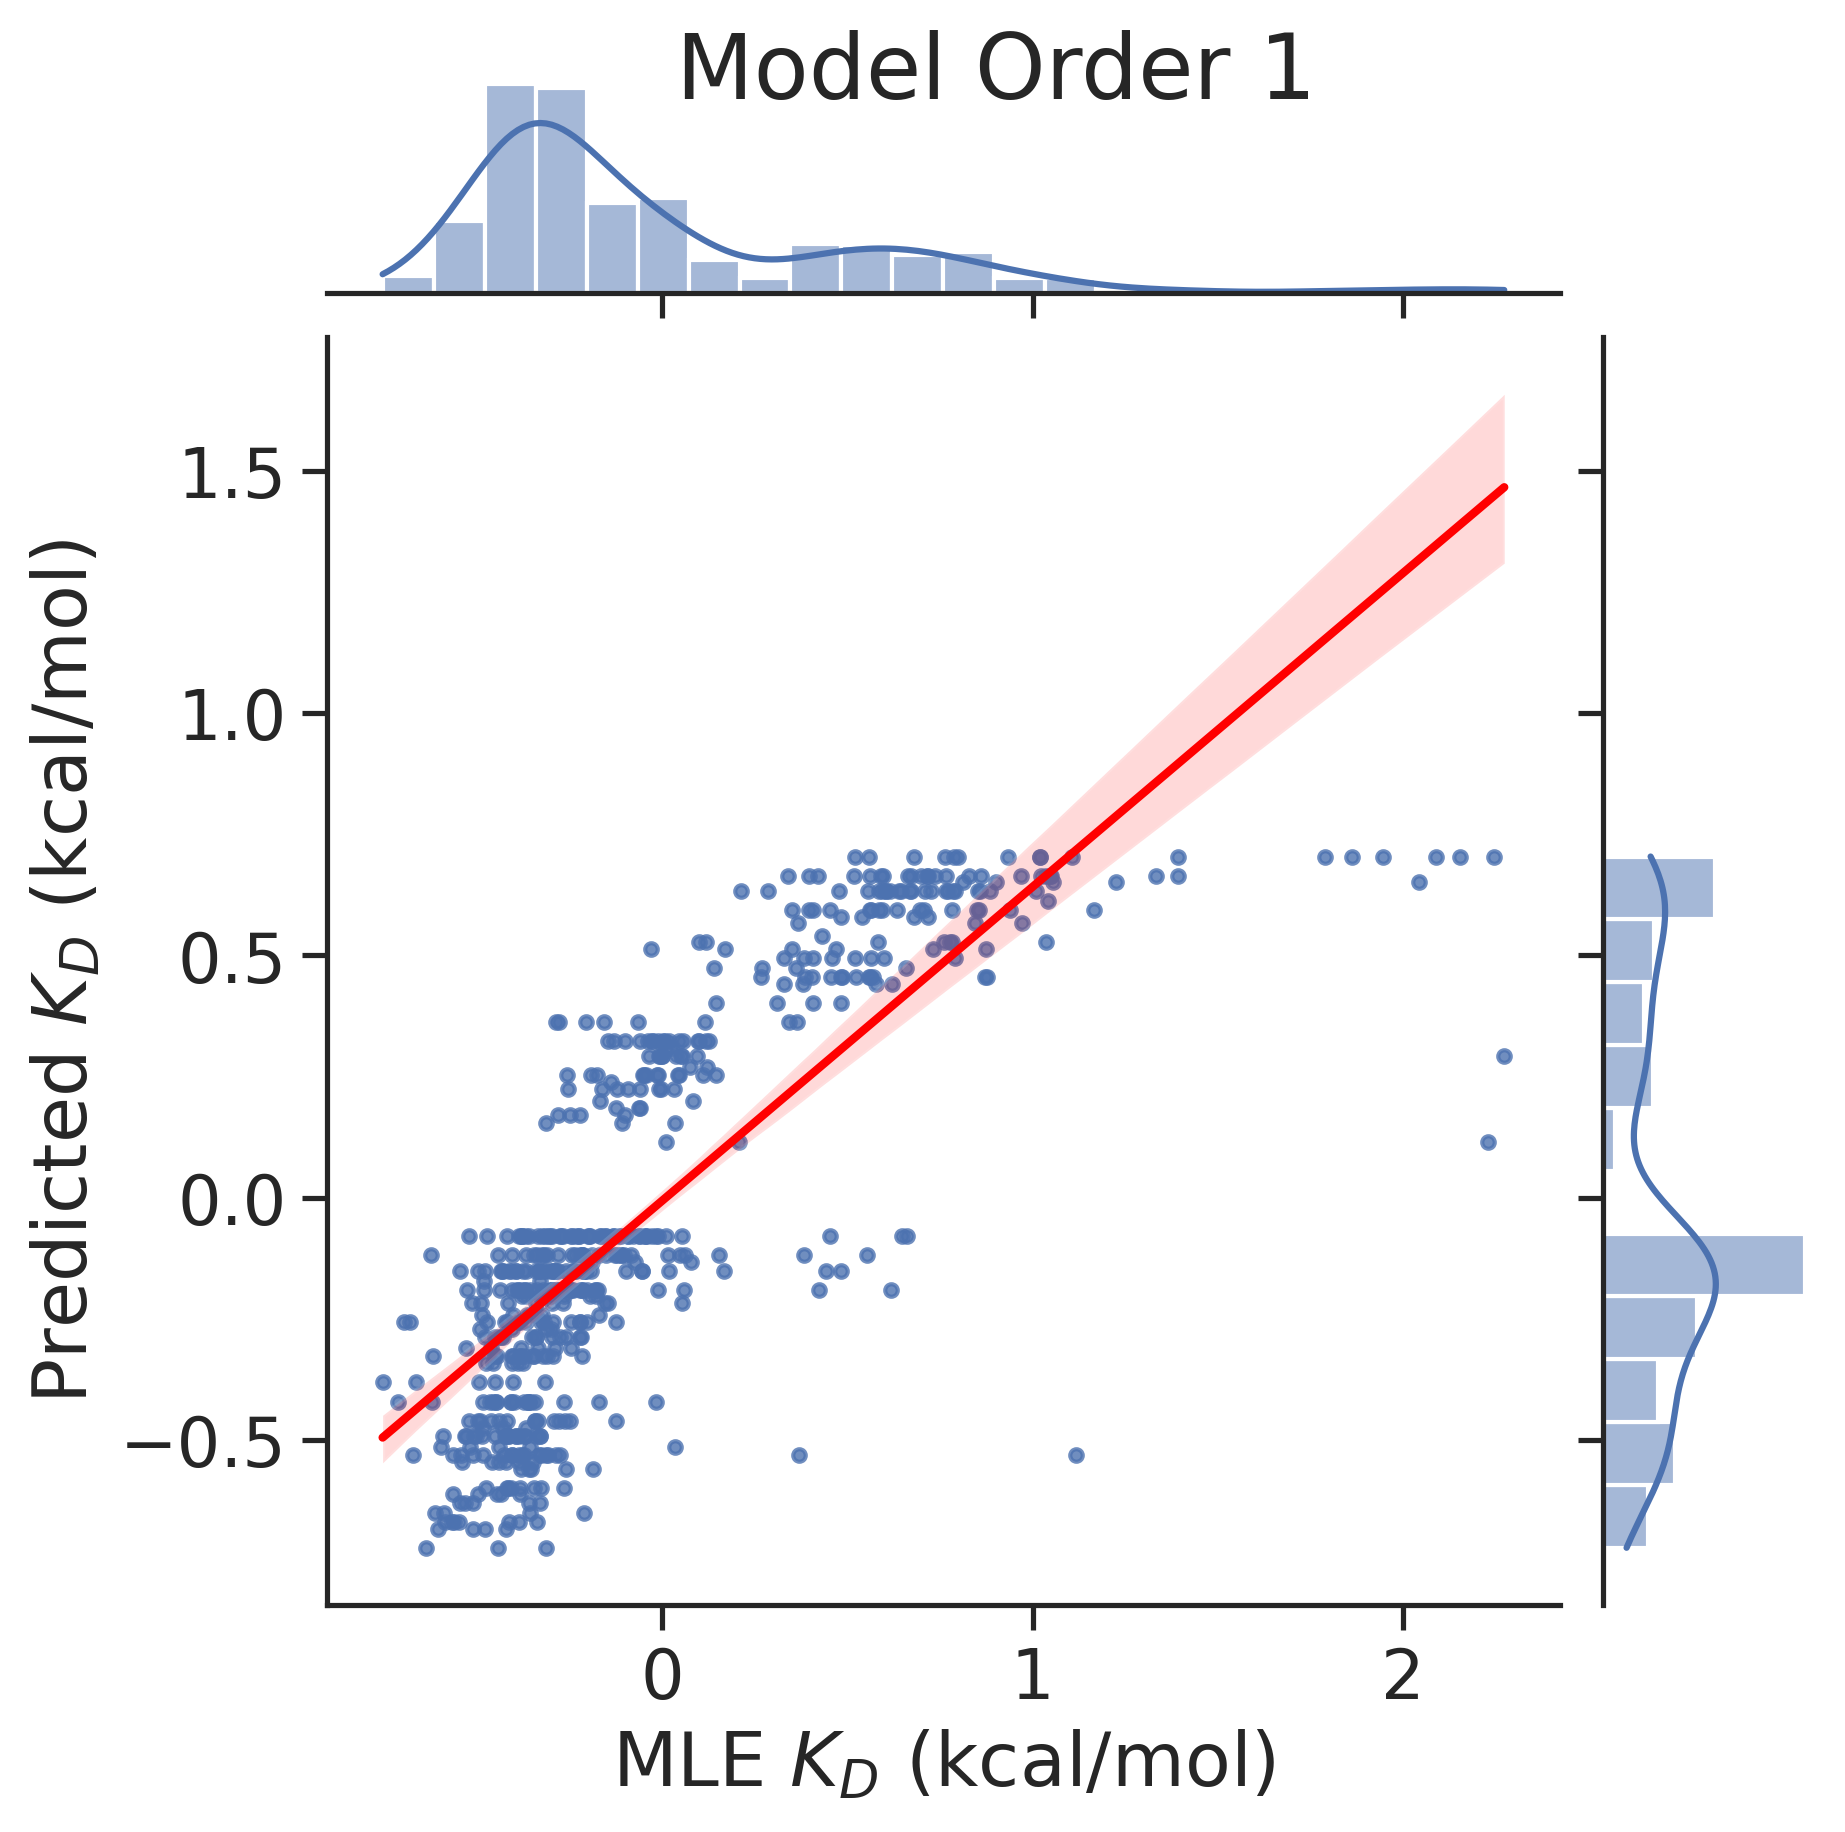

<Figure size 600x600 with 0 Axes>

In [51]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (2, 2),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

order = 1
print("Order: ", str(order))
poly_current = PolynomialFeatures(order, interaction_only=True)
genos_transform = poly_current.fit_transform(genotypes)

lasso = lasso(alpha=0.7)
lasso.fit(genos_transform, affinities)
coef_names = poly_current.get_feature_names_out(input_features=mutations)
reg_coefs_current = lasso.coef_
print("Weights")
for name, coef in zip(coef_names, reg_coefs_current):
    print(f"{name}: {round(coef, 3)}")
print("")
r2 = lasso.score(genos_transform, affinities)
print("R^2:", r2)
predicted = lasso.predict(genos_transform)

print(f"\n\nORDER: {order}\n\n")
plot = sns.jointplot(
    x=affinities,
    y=predicted,
    kind="reg",
    line_kws={"lw": 2, "color": "red"},
    marker=".",
)
plot.fig.suptitle(f"Model Order {order}")
plot.ax_joint.set_xlabel(r"MLE $K_D$ (kcal/mol)")
plot.ax_joint.set_ylabel(r"Predicted $K_D$ (kcal/mol)")
plt.show()
# plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
plt.clf()

Order:  2
Weights
1: 0.0
D110E-GAG: -0.048
M59I-ATC: -0.043
Q120K-AAA: 0.083
S7T-ACT: -0.002
T94M-ATG: 0.898
V109L-CTG: -0.064
D110E-GAG M59I-ATC: -0.002
D110E-GAG Q120K-AAA: 0.061
D110E-GAG S7T-ACT: 0.034
D110E-GAG T94M-ATG: -0.077
D110E-GAG V109L-CTG: -0.098
M59I-ATC Q120K-AAA: -0.18
M59I-ATC S7T-ACT: -0.108
M59I-ATC T94M-ATG: -0.547
M59I-ATC V109L-CTG: 0.15
Q120K-AAA S7T-ACT: 0.09
Q120K-AAA T94M-ATG: 0.096
Q120K-AAA V109L-CTG: -0.1
S7T-ACT T94M-ATG: 0.128
S7T-ACT V109L-CTG: -0.067
T94M-ATG V109L-CTG: -0.067

R^2: 0.7446981857277933


ORDER: 2




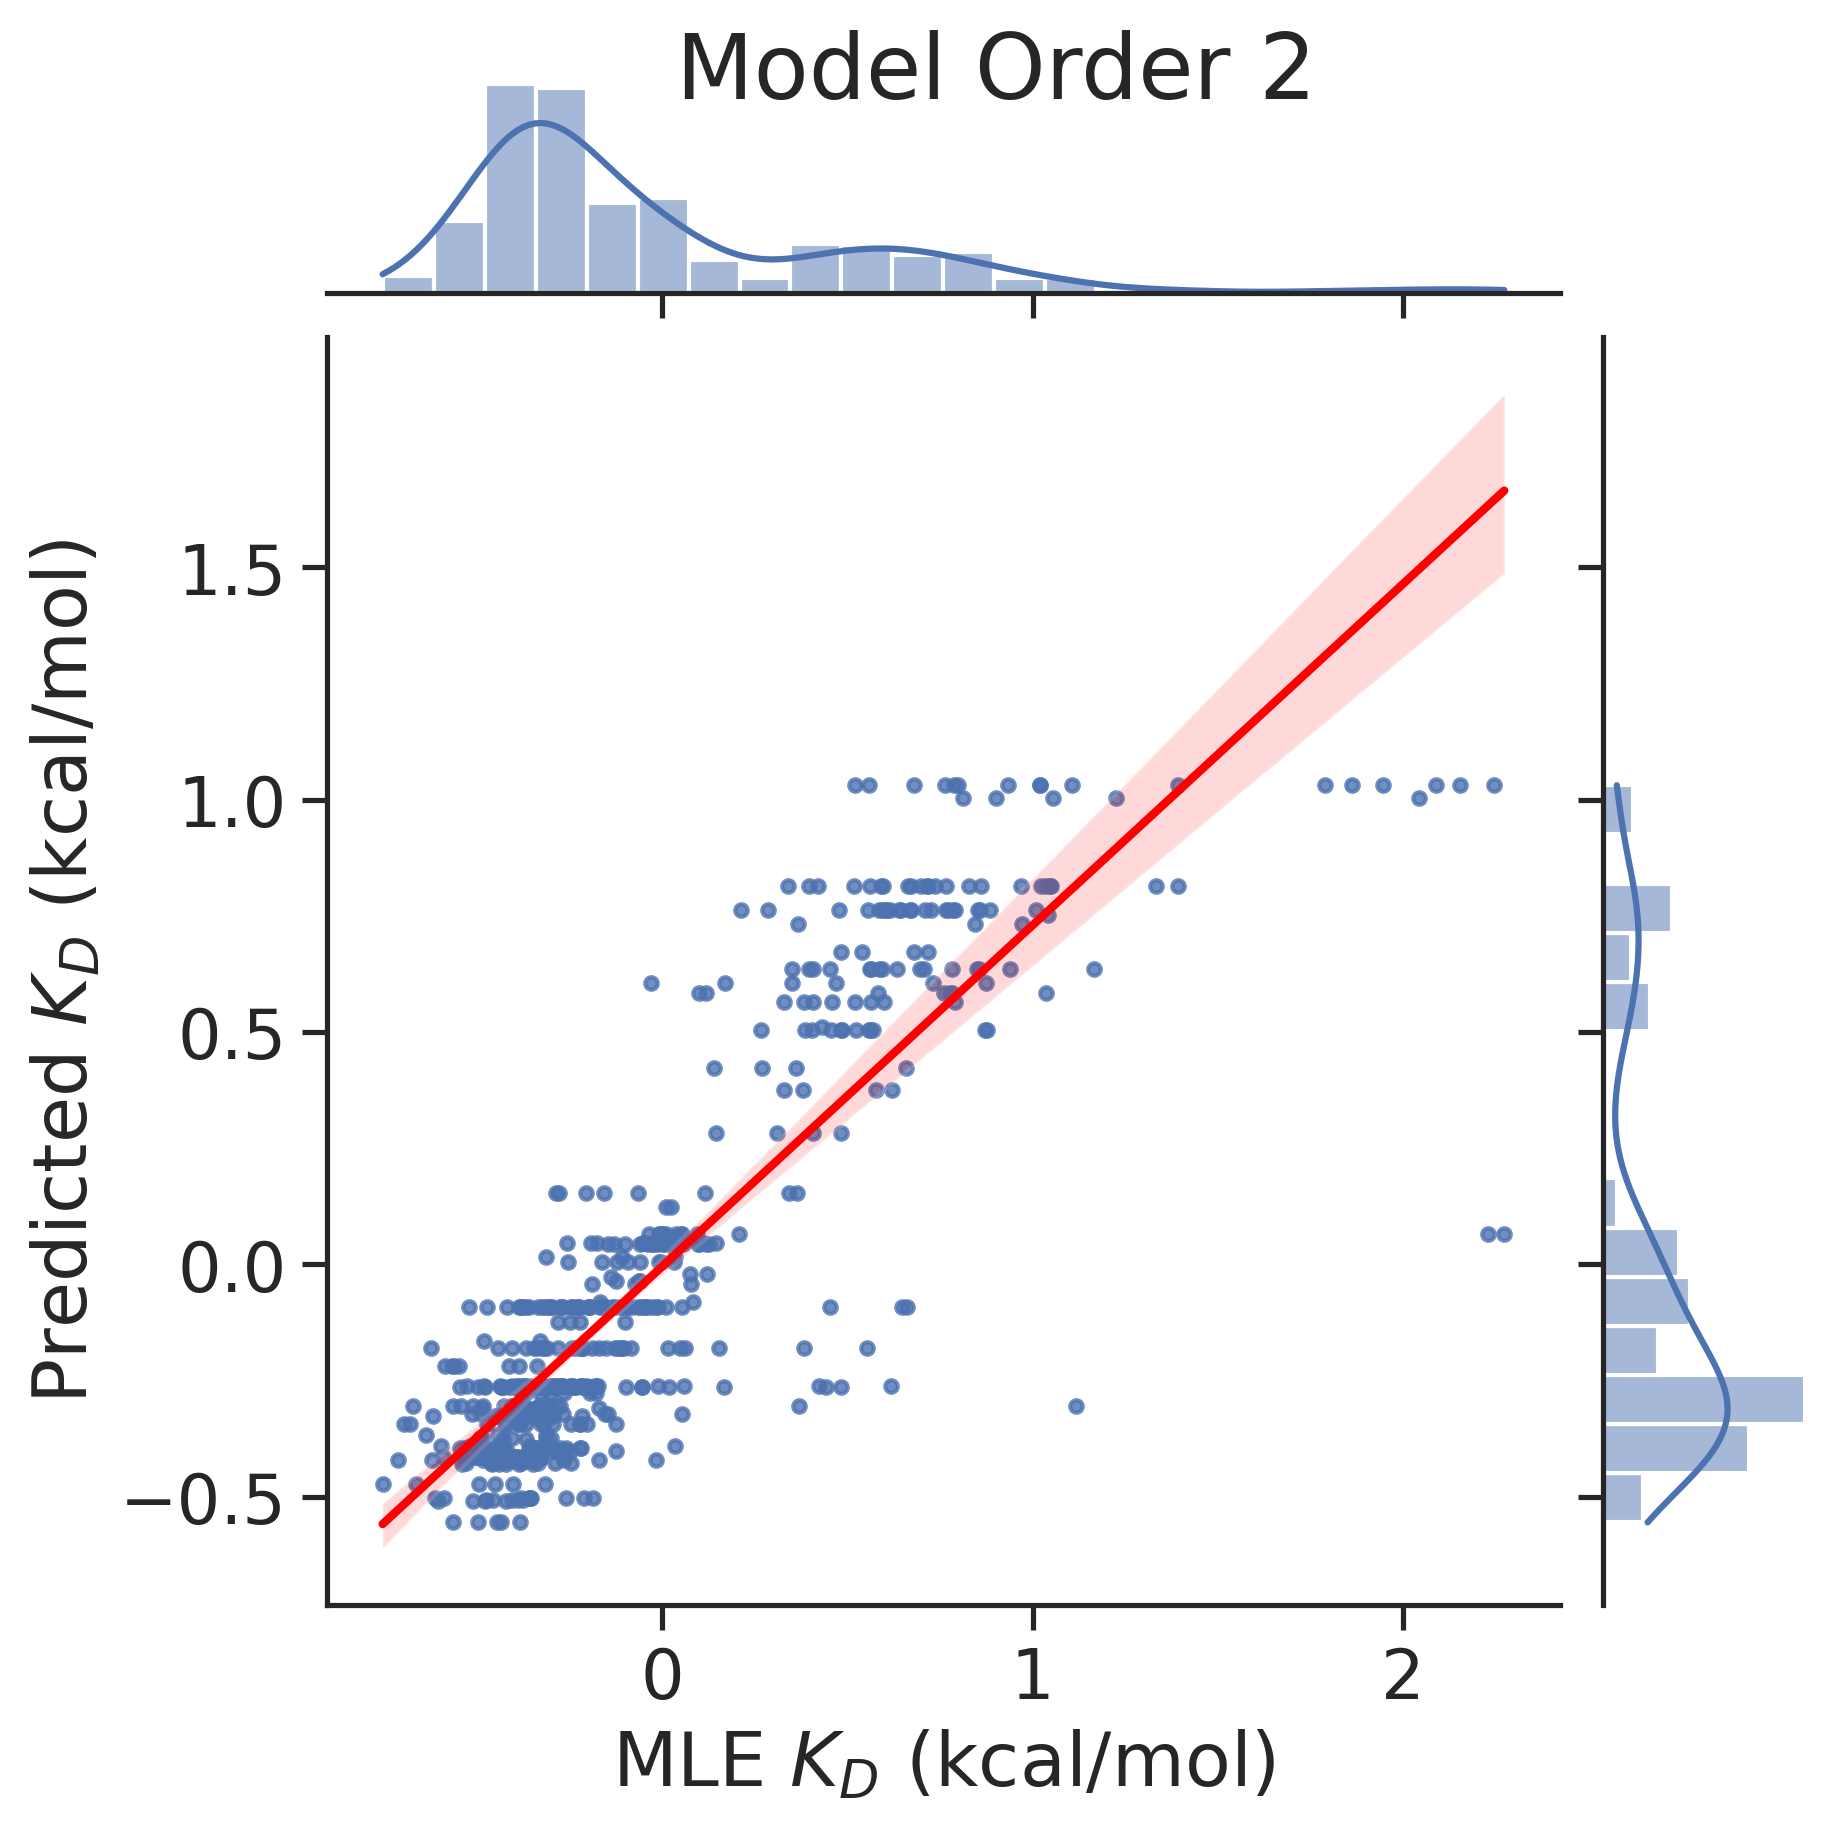

<Figure size 600x600 with 0 Axes>

In [50]:
order = 2
print("Order: ", str(order))
poly_current = PolynomialFeatures(order, interaction_only=True)
genos_transform = poly_current.fit_transform(genotypes)

lasso = lasso(alpha=1.22)
lasso.fit(genos_transform, affinities)
coef_names = poly_current.get_feature_names_out(input_features=mutations)
reg_coefs_current = lasso.coef_
print("Weights")
for name, coef in zip(coef_names, reg_coefs_current):
    print(f"{name}: {round(coef, 3)}")
print("")

r2 = lasso.score(genos_transform, affinities)
print("R^2:", r2)
predicted = lasso.predict(genos_transform)

print(f"\n\nORDER: {order}\n\n")
plot = sns.jointplot(
    x=affinities,
    y=predicted,
    kind="reg",
    line_kws={"lw": 2, "color": "red"},
    marker=".",
)
plot.fig.suptitle(f"Model Order {order}")
plot.ax_joint.set_xlabel(r"MLE $K_D$ (kcal/mol)")
plot.ax_joint.set_ylabel(r"Predicted $K_D$ (kcal/mol)")
plt.show()
# plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
plt.clf()